In [50]:
import sys

req_link = '/usr/local/lib/python2.7/site-packages/'
sys.path.append(req_link)

from keras import backend as K
K.set_image_dim_ordering('th')

import numpy as np
np.random.seed(123)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import model_from_json
import glob
import cv2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib
import brewer2mpl
import pandas as pd

set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
%matplotlib inline

# 1. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print (X_train.shape)

# 2. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# 3. Preprocess class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
    
def train_model():

    # 4. Define model architecture
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,28,28)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # 5. Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # 6. Fit model on training data
    model.fit(X_train, Y_train, 
              batch_size=32, epochs=10, verbose=1)

    # 7. serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    # 8. serialize weights to HDF5
    model.save_weights("model.h5", overwrite=True)
    print("Saved model to disk")
    print ("hi")
    return model

(60000, 28, 28)


In [51]:
def load_model(X_test, Y_test):
    # 9. load json and create model
    json_file = open('model.json', 'r')
    loadmodel = json_file.read()
    json_file.close()
    model = model_from_json(loadmodel)

    # 10. load weights into new model
    model.load_weights("model.h5")
    print("Loaded model from disk") 

    # 11. Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print("Compiled loaded model") 
    
    # 11. Evaluate model on test data
    score = model.evaluate(X_test, Y_test, verbose=0)
    print score
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return model

In [52]:
# 12. predict

def processImage(path):
    x = cv2.imread(path)
    x = cv2.resize(x,(28, 28))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x = x.reshape(1, 1, 28, 28)
    x = x.astype('float32')
    x /= 255
    return x


def getLabel(label):
    
    pattern = ([0]*label)+[1]+([0]*(9-label))
    print pattern
    label = np.array(pattern) 
    
    label = label.reshape(1, 10)
    return label

def predict(image, label, model):
    
    label = getLabel(label)
    
    score = model.evaluate(image, label, verbose=0)
    pred_array = model.predict(image)
    pred_class = model.predict_classes(image)

    prediction = (score, pred_array, pred_class)
    
    return prediction

def select(number):
    try:
        x = processImage(str(number)+".png")
    except:
        x = processImage(str(number)+".jpeg")
    return x

In [53]:
from pprint import pprint
model = load_model(X_test, Y_test)

Loaded model from disk
Compiled loaded model
[0.027639551383534036, 0.99209999999999998]
('Test loss:', 0.027639551383534036)
('Test accuracy:', 0.99209999999999998)


In [54]:
pprint (predict(select("six"), 6, model))

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
([0.25391355156898499, 1.0],
 array([[  1.72687009e-01,   2.10482700e-04,   1.10050347e-02,
          3.74921062e-03,   1.04158198e-05,   2.71610711e-02,
          7.75758862e-01,   8.58668227e-06,   9.15566180e-03,
          2.53619597e-04]], dtype=float32),
 array([6]))


In [55]:
def overview(start, end, X):
    fig = plt.figure(figsize=(8,10))
    for i in range(start, end+1):
        print(i)
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

0
1
2
3
4
5
6
7
8
9
10


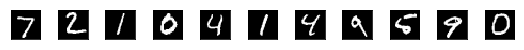

In [56]:
overview(0,10, X_test)

In [208]:
def plot_filters(layer, x, y):
    filters = layer.kernel.get_value()
    fig = plt.figure(figsize=(8, 4))
    for j in range(len(filters)):
        ax = fig.add_subplot(y, x, j+1)
        ax.matshow(filters[j][0], cmap = matplotlib.cm.Blues)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

In [209]:
# plot_filters(model.layers[1], 8, 4)

TypeError: 'Variable' object is not callable

(1, 1, 28, 28)


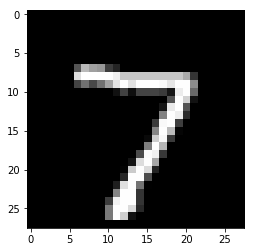

In [204]:
input_img = X_test[0:1,0:1,0:28,0:28] # subject0
print input_img.shape
plt.imshow(input_img[0,0,:,:], cmap='gray')

In [148]:
from sklearn.metrics import confusion_matrix

y_prob = model.predict(X_test, batch_size=32, verbose=0)
y_true =[np.argmax(prob) for prob in y_prob]
y_pred= [np.argmax(prob) for prob in y_test]

In [171]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(y_test) if label == emotion.all()][0]
    col = [cm[j,i] for j in range(0,9)]
#     print col
    try:
        return float(col[i])/sum(col)
    except Exception as e:
        return e

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(y_test) if label == emotion.all()][0]
    row = [cm[i,j] for j in range(0,9)]
#     print row
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(y_test) if label == emotion.all()][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,9) if j != i])
    fp = sum([cm[j,i] for j in range(0,9) if j != i])
    tn = sum([cm[i,j] for j in range(0,9) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

print class_precision(y_true, y_pred, getLabel(3))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
float division by zero


In [172]:
print class_recall(y_true, y_pred, getLabel(3))
print class_accuracy(y_true, y_pred, getLabel(3))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
0.0
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
0.831016219795
